# Domain Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import sys
sys.path.append("../..")

In [2]:
from collections import defaultdict
import ipaddress
import os.path

import matplotlib
import networkx as nx

matplotlib.rcParams['figure.figsize'] = (9.5, 8)

## Load Full DNS Graph

In [3]:
from netanalysis.analysis.analysis_app import AnalysisApp

app = AnalysisApp(os.path.join(os.getcwd(), "..", "..", "ooni_data"))

IntProgress(value=0, description='Loading')

## Create Domain Graph

In [5]:
domain_app = app.domain_app("www.youtube.com")
print("Graph nodes: %s" % ", ".join(sorted(domain_app.domain_graph.nodes)))
print("Parent domains: %s" % (set(nx.dfs_preorder_nodes(app.dns_graph.reverse(copy=False), domain_app.domain)) - set([domain_app.domain])))

Graph nodes: 10.10.34.0/24, 108.177.14.0/24, 108.177.15.0/24, 172.217.0.0/24, 172.217.1.0/24, 172.217.10.0/24, 172.217.11.0/24, 172.217.12.0/24, 172.217.13.0/24, 172.217.14.0/24, 172.217.15.0/24, 172.217.16.0/24, 172.217.160.0/24, 172.217.161.0/24, 172.217.164.0/24, 172.217.166.0/24, 172.217.17.0/24, 172.217.18.0/24, 172.217.19.0/24, 172.217.2.0/24, 172.217.20.0/24, 172.217.21.0/24, 172.217.22.0/24, 172.217.23.0/24, 172.217.24.0/24, 172.217.25.0/24, 172.217.26.0/24, 172.217.27.0/24, 172.217.29.0/24, 172.217.3.0/24, 172.217.30.0/24, 172.217.31.0/24, 172.217.4.0/24, 172.217.5.0/24, 172.217.6.0/24, 172.217.7.0/24, 172.217.8.0/24, 172.217.9.0/24, 173.194.220.0/24, 173.194.221.0/24, 173.194.73.0/24, 173.194.76.0/24, 209.85.144.0/24, 209.85.202.0/24, 209.85.203.0/24, 209.85.233.0/24, 216.58.192.0/24, 216.58.193.0/24, 216.58.194.0/24, 216.58.195.0/24, 216.58.196.0/24, 216.58.197.0/24, 216.58.198.0/24, 216.58.199.0/24, 216.58.200.0/24, 216.58.201.0/24, 216.58.202.0/24, 216.58.203.0/24, 216.58.

## Classify Edges

<IPython.core.display.Javascript object>


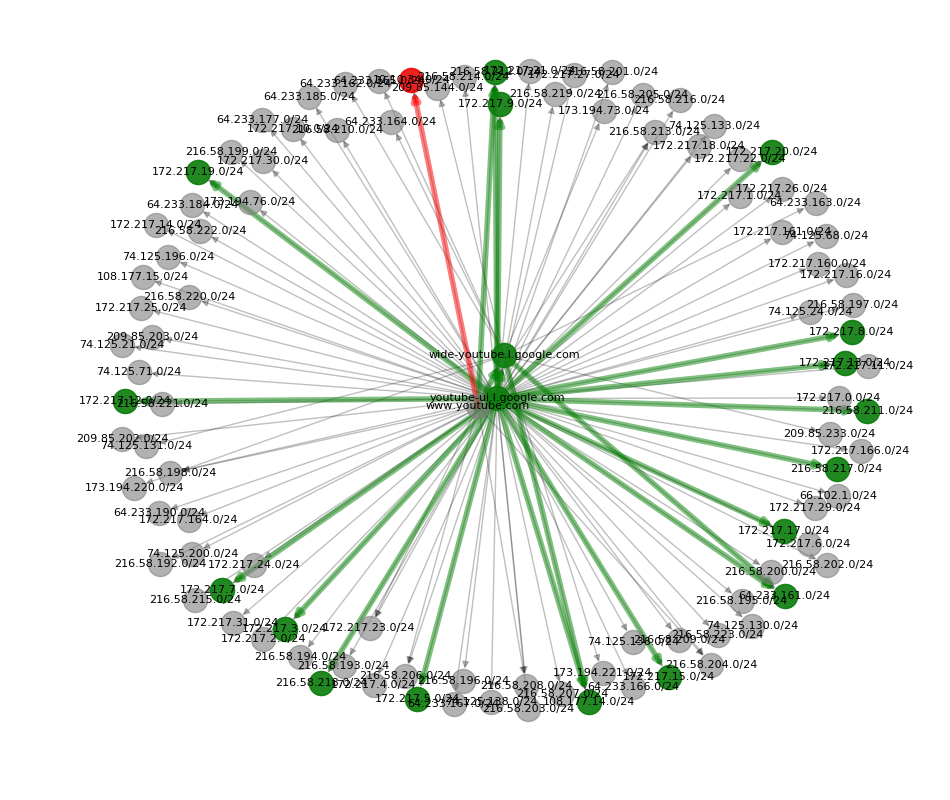

In [6]:
domain_app.display_graph()

## Use TLS to verify UNKNOWNs

At this stage we use TLS validation of certificates to check if an IP is valid for a domain

Checking IPs for wide-youtube.l.google.com - 74.125.131.0/24
    Validating 74.125.131.198: CertificateError("hostname 'wide-youtube.l.google.com' doesn't match either of 'google.com', '*.2mdn.net', '*.android.com', '*.appengine.google.com', '*.au.doubleclick.net', '*.cc-dt.com', '*.cloud.google.com', '*.db833953.google.cn', '*.de.doubleclick.net', '*.doubleclick.com', '*.doubleclick.net', '*.fls.doubleclick.net', '*.fr.doubleclick.net', '*.g.co', '*.gcp.gvt2.com', '*.google-analytics.com', '*.google.ac', '*.google.ad', '*.google.ae', '*.google.af', '*.google.ag', '*.google.ai', '*.google.al', '*.google.am', '*.google.as', '*.google.at', '*.google.az', '*.google.ba', '*.google.be', '*.google.bf', '*.google.bg', '*.google.bi', '*.google.bj', '*.google.bs', '*.google.bt', '*.google.by', '*.google.ca', '*.google.cat', '*.google.cc', '*.google.cd', '*.google.cf', '*.google.cg', '*.google.ch', '*.google.ci', '*.google.cl', '*.google.cm', '*.google.cn', '*.google.co.ao', '*.google.co.bw', '*

    Validating 64.233.162.198: TimeoutError()
Checking IPs for wide-youtube.l.google.com - 64.233.164.0/24
    Validating 64.233.164.198: CertificateError("hostname 'wide-youtube.l.google.com' doesn't match either of 'google.com', '*.2mdn.net', '*.android.com', '*.appengine.google.com', '*.au.doubleclick.net', '*.cc-dt.com', '*.cloud.google.com', '*.db833953.google.cn', '*.de.doubleclick.net', '*.doubleclick.com', '*.doubleclick.net', '*.fls.doubleclick.net', '*.fr.doubleclick.net', '*.g.co', '*.gcp.gvt2.com', '*.google-analytics.com', '*.google.ac', '*.google.ad', '*.google.ae', '*.google.af', '*.google.ag', '*.google.ai', '*.google.al', '*.google.am', '*.google.as', '*.google.at', '*.google.az', '*.google.ba', '*.google.be', '*.google.bf', '*.google.bg', '*.google.bi', '*.google.bj', '*.google.bs', '*.google.bt', '*.google.by', '*.google.ca', '*.google.cat', '*.google.cc', '*.google.cd', '*.google.cf', '*.google.cg', '*.google.ch', '*.google.ci', '*.google.cl', '*.google.cm', '*.goog

    Validating 64.233.163.198: CertificateError("hostname 'wide-youtube.l.google.com' doesn't match either of 'google.com', '*.2mdn.net', '*.android.com', '*.appengine.google.com', '*.au.doubleclick.net', '*.cc-dt.com', '*.cloud.google.com', '*.db833953.google.cn', '*.de.doubleclick.net', '*.doubleclick.com', '*.doubleclick.net', '*.fls.doubleclick.net', '*.fr.doubleclick.net', '*.g.co', '*.gcp.gvt2.com', '*.google-analytics.com', '*.google.ac', '*.google.ad', '*.google.ae', '*.google.af', '*.google.ag', '*.google.ai', '*.google.al', '*.google.am', '*.google.as', '*.google.at', '*.google.az', '*.google.ba', '*.google.be', '*.google.bf', '*.google.bg', '*.google.bi', '*.google.bj', '*.google.bs', '*.google.bt', '*.google.by', '*.google.ca', '*.google.cat', '*.google.cc', '*.google.cd', '*.google.cf', '*.google.cg', '*.google.ch', '*.google.ci', '*.google.cl', '*.google.cm', '*.google.cn', '*.google.co.ao', '*.google.co.bw', '*.google.co.ck', '*.google.co.cr', '*.google.co.hu', '*.google

    Validating 173.194.221.198: CertificateError("hostname 'wide-youtube.l.google.com' doesn't match either of 'google.com', '*.2mdn.net', '*.android.com', '*.appengine.google.com', '*.au.doubleclick.net', '*.cc-dt.com', '*.cloud.google.com', '*.db833953.google.cn', '*.de.doubleclick.net', '*.doubleclick.com', '*.doubleclick.net', '*.fls.doubleclick.net', '*.fr.doubleclick.net', '*.g.co', '*.gcp.gvt2.com', '*.google-analytics.com', '*.google.ac', '*.google.ad', '*.google.ae', '*.google.af', '*.google.ag', '*.google.ai', '*.google.al', '*.google.am', '*.google.as', '*.google.at', '*.google.az', '*.google.ba', '*.google.be', '*.google.bf', '*.google.bg', '*.google.bi', '*.google.bj', '*.google.bs', '*.google.bt', '*.google.by', '*.google.ca', '*.google.cat', '*.google.cc', '*.google.cd', '*.google.cf', '*.google.cg', '*.google.ch', '*.google.ci', '*.google.cl', '*.google.cm', '*.google.cn', '*.google.co.ao', '*.google.co.bw', '*.google.co.ck', '*.google.co.cr', '*.google.co.hu', '*.googl

    Validating 173.194.220.198: CertificateError("hostname 'wide-youtube.l.google.com' doesn't match either of 'google.com', '*.2mdn.net', '*.android.com', '*.appengine.google.com', '*.au.doubleclick.net', '*.cc-dt.com', '*.cloud.google.com', '*.db833953.google.cn', '*.de.doubleclick.net', '*.doubleclick.com', '*.doubleclick.net', '*.fls.doubleclick.net', '*.fr.doubleclick.net', '*.g.co', '*.gcp.gvt2.com', '*.google-analytics.com', '*.google.ac', '*.google.ad', '*.google.ae', '*.google.af', '*.google.ag', '*.google.ai', '*.google.al', '*.google.am', '*.google.as', '*.google.at', '*.google.az', '*.google.ba', '*.google.be', '*.google.bf', '*.google.bg', '*.google.bi', '*.google.bj', '*.google.bs', '*.google.bt', '*.google.by', '*.google.ca', '*.google.cat', '*.google.cc', '*.google.cd', '*.google.cf', '*.google.cg', '*.google.ch', '*.google.ci', '*.google.cl', '*.google.cm', '*.google.cn', '*.google.co.ao', '*.google.co.bw', '*.google.co.ck', '*.google.co.cr', '*.google.co.hu', '*.googl

    Validating 173.194.73.198: CertificateError("hostname 'wide-youtube.l.google.com' doesn't match either of 'google.com', '*.2mdn.net', '*.android.com', '*.appengine.google.com', '*.au.doubleclick.net', '*.cc-dt.com', '*.cloud.google.com', '*.db833953.google.cn', '*.de.doubleclick.net', '*.doubleclick.com', '*.doubleclick.net', '*.fls.doubleclick.net', '*.fr.doubleclick.net', '*.g.co', '*.gcp.gvt2.com', '*.google-analytics.com', '*.google.ac', '*.google.ad', '*.google.ae', '*.google.af', '*.google.ag', '*.google.ai', '*.google.al', '*.google.am', '*.google.as', '*.google.at', '*.google.az', '*.google.ba', '*.google.be', '*.google.bf', '*.google.bg', '*.google.bi', '*.google.bj', '*.google.bs', '*.google.bt', '*.google.by', '*.google.ca', '*.google.cat', '*.google.cc', '*.google.cd', '*.google.cf', '*.google.cg', '*.google.ch', '*.google.ci', '*.google.cl', '*.google.cm', '*.google.cn', '*.google.co.ao', '*.google.co.bw', '*.google.co.ck', '*.google.co.cr', '*.google.co.hu', '*.google

    Validating 209.85.233.198: CertificateError("hostname 'wide-youtube.l.google.com' doesn't match either of 'google.com', '*.2mdn.net', '*.android.com', '*.appengine.google.com', '*.au.doubleclick.net', '*.cc-dt.com', '*.cloud.google.com', '*.db833953.google.cn', '*.de.doubleclick.net', '*.doubleclick.com', '*.doubleclick.net', '*.fls.doubleclick.net', '*.fr.doubleclick.net', '*.g.co', '*.gcp.gvt2.com', '*.google-analytics.com', '*.google.ac', '*.google.ad', '*.google.ae', '*.google.af', '*.google.ag', '*.google.ai', '*.google.al', '*.google.am', '*.google.as', '*.google.at', '*.google.az', '*.google.ba', '*.google.be', '*.google.bf', '*.google.bg', '*.google.bi', '*.google.bj', '*.google.bs', '*.google.bt', '*.google.by', '*.google.ca', '*.google.cat', '*.google.cc', '*.google.cd', '*.google.cf', '*.google.cg', '*.google.ch', '*.google.ci', '*.google.cl', '*.google.cm', '*.google.cn', '*.google.co.ao', '*.google.co.bw', '*.google.co.ck', '*.google.co.cr', '*.google.co.hu', '*.google

    Validating 64.233.165.198: CertificateError("hostname 'wide-youtube.l.google.com' doesn't match either of 'google.com', '*.2mdn.net', '*.android.com', '*.appengine.google.com', '*.au.doubleclick.net', '*.cc-dt.com', '*.cloud.google.com', '*.db833953.google.cn', '*.de.doubleclick.net', '*.doubleclick.com', '*.doubleclick.net', '*.fls.doubleclick.net', '*.fr.doubleclick.net', '*.g.co', '*.gcp.gvt2.com', '*.google-analytics.com', '*.google.ac', '*.google.ad', '*.google.ae', '*.google.af', '*.google.ag', '*.google.ai', '*.google.al', '*.google.am', '*.google.as', '*.google.at', '*.google.az', '*.google.ba', '*.google.be', '*.google.bf', '*.google.bg', '*.google.bi', '*.google.bj', '*.google.bs', '*.google.bt', '*.google.by', '*.google.ca', '*.google.cat', '*.google.cc', '*.google.cd', '*.google.cf', '*.google.cg', '*.google.ch', '*.google.ci', '*.google.cl', '*.google.cm', '*.google.cn', '*.google.co.ao', '*.google.co.bw', '*.google.co.ck', '*.google.co.cr', '*.google.co.hu', '*.google

    Validating 216.58.213.110: VALID
Checking IPs for www.youtube.com - 172.217.23.0/24
    Validating 172.217.23.174: VALID
Checking IPs for www.youtube.com - 216.58.206.0/24
    Validating 216.58.206.238: VALID
Checking IPs for www.youtube.com - 216.58.204.0/24
    Validating 216.58.204.78: VALID
Checking IPs for www.youtube.com - 216.58.198.0/24
    Validating 216.58.198.238: VALID
Checking IPs for www.youtube.com - 216.58.208.0/24
    Validating 216.58.208.78: VALID
Checking IPs for www.youtube.com - 74.125.131.0/24
    Validating 74.125.131.198: VALID
Checking IPs for www.youtube.com - 64.233.162.0/24
    Validating 64.233.162.198: TimeoutError()
Checking IPs for www.youtube.com - 64.233.164.0/24
    Validating 64.233.164.198: VALID
Checking IPs for www.youtube.com - 64.233.163.0/24
    Validating 64.233.163.198: VALID
Checking IPs for www.youtube.com - 209.85.144.0/24
    Validating 209.85.144.198: VALID
Checking IPs for www.youtube.com - 173.194.221.0/24
    Validating 173.194.2

<IPython.core.display.Javascript object>


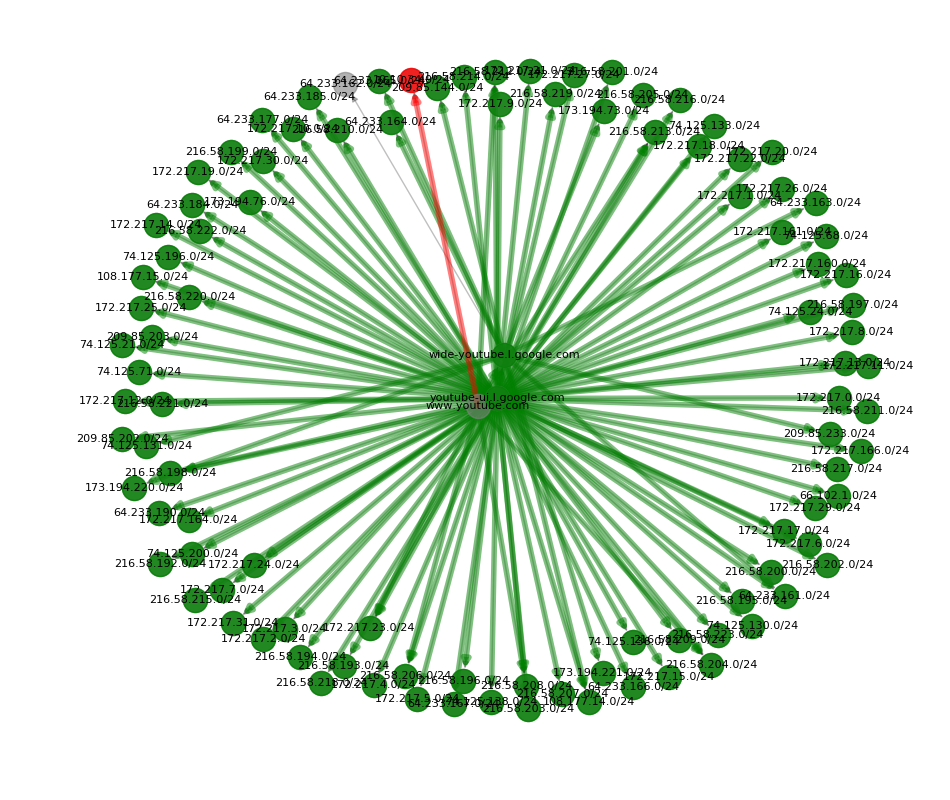

In [7]:
domain_app.tls_verify_unknowns()
domain_app.display_graph()

## Classify Measurements

In [8]:
from netanalysis.dns import classifier as dc

def analyze_measurements(domain: str, domain_graph, class_graph, results=None):
    measurements = dict()  # type: Dict[str, dns.DnsMeasurement]
    for u, v, data in domain_graph.edges(data=True):
        measurement = data.get("measurement")
        if not measurement:
            continue
        if measurement.trust_reason:
            continue
        if measurement.records[0].name.lower() != domain:
            continue
        measurements[measurement.measurement_id] = measurement


    for measurement in sorted(measurements.values(), key=lambda m: m.time):
        measurement_eval = dc.Evaluation(dc.EdgeClass.UNKNOWN, None)
        ips = []
        for record in measurement.records:
            try:
                ip = record.data.ip
                ips.append(ip)
            except AttributeError:
                continue
            
        for ip in ips:
            net = str(ipaddress.ip_network(ip).supernet(new_prefix=24))
            evaluation = class_graph[domain][net]["eval"]
            if evaluation.classification != dc.EdgeClass.UNKNOWN:
                measurement_eval = evaluation
                break
        if not results or measurement_eval.classification in results:
            print("{} {} {}, IPs: [{}] (DNS: {})".format(
                measurement.time,
                measurement.client_country,
                measurement_eval.classification.name,
                ", ".join(str(ip) for ip in ips),
                measurement.resolver_ip
            ))

analyze_measurements(domain_app.domain,
                     domain_app.domain_graph,
                     domain_app.classifier.class_graph,
                     results=[dc.EdgeClass.UNKNOWN, dc.EdgeClass.BAD])

2018-02-27 01:09:48 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 74.125.46.6)
2018-02-27 01:28:56 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 74.125.46.3)
2018-02-27 01:44:42 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 173.194.98.8)
2018-02-27 02:09:26 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 74.125.46.11)
2018-02-27 02:09:43 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 74.125.46.11)
2018-02-27 02:22:33 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 74.125.46.3)
2018-02-27 02:33:39 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 173.194.98.15)
2018-02-27 02:33:44 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 173.194.98.15)
2018-02-27 03:06:53 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 74.125.46.4)
2018-02-27 03:07:02 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 74.125.46.4)
2018-02-27 04:33:06 IR BAD, IPs: [10.10.34.35] (DNS: 74.125.181.3)
2018-02-27 04:46:14 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 74.125.46.2)
2018-02-27 05:00:16 RU UNKNOWN, IPs: [64.233.162.198] (DNS: 173.194.98.5)
2018-02-27 05:03:37 RU UNKNOWN, IPs: [64.233.162.

## Analyze a country

<IPython.core.display.Javascript object>


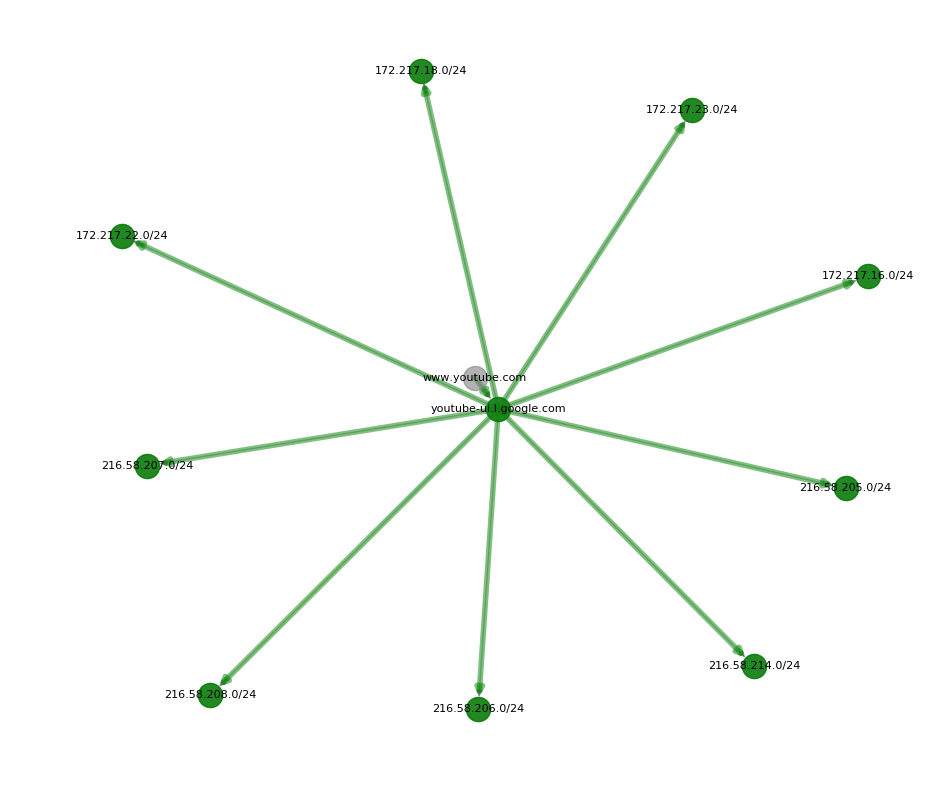

In [9]:
domain_app.display_graph(country="UA")

## Investigate an IP Address

In [10]:
from IPython.display import display
import ipywidgets as widgets
from netanalysis.analysis import ip_info_widget
import netanalysis.analysis.simple_autonomous_system as sas

as_repo = sas.create_default_as_repo()
ip_tab = ip_info_widget.create_ip_info_widget(as_repo)
tabs = widgets.Tab()
tabs.set_title(0, "IP Info")
tabs.children = [ip_tab]
tabs

Tab(children=(VBox(children=(HBox(children=(Text(value='', description='IP', placeholder='Enter ip address'), Button(description='Get info', style=ButtonStyle()))), Output())),), _titles={'0': 'IP Info'})